# Laboratorium 3

### Konfiguracja

In [93]:
import functools
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import random
import heapq
from sortedcontainers import SortedSet
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [94]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


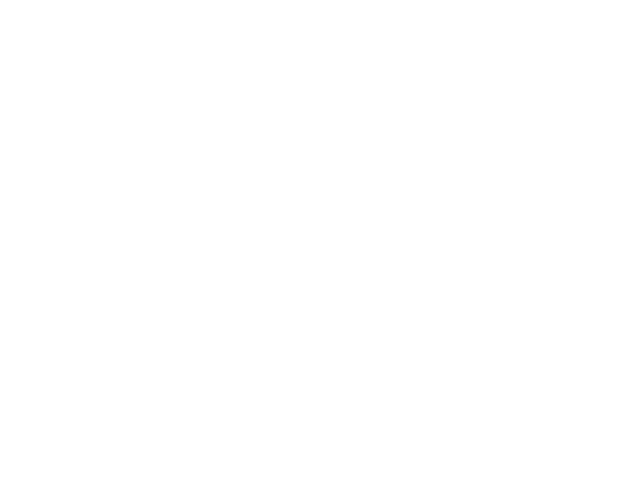

In [95]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 

<IPython.core.display.Javascript object>


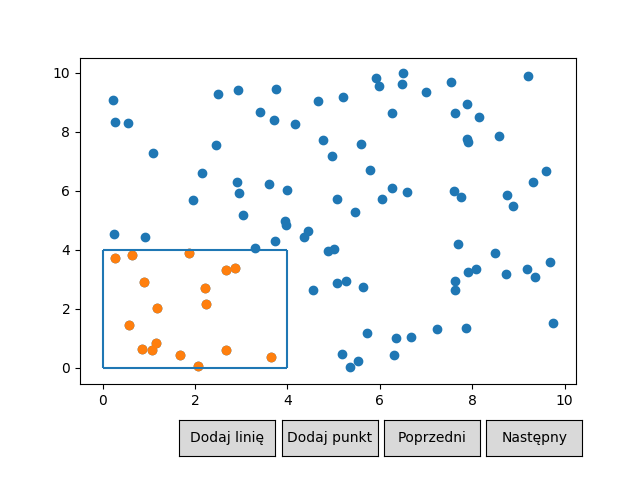

In [96]:
class Point:

    def __init__(self, x: float, y: float) -> None:
        super().__init__()
        self.x = x
        self.y = y

    def get_tuple(self):
        return self.x, self.y

class Range:

    def __init__(self, lower_left: Point, upper_right: Point) -> None:
        super().__init__()
        self.lower_left = lower_left
        self.upper_right = upper_right

    def get_width(self):
        return self.upper_right.x - self.lower_left.x

    def get_height(self):
        return self.upper_right.y - self.lower_left.y

    def intersects(self, range: 'Range'):
        half_width_a = self.get_width() / 2
        half_height_a = self.get_height() / 2
        half_width_b = range.get_width() / 2
        half_height_b = range.get_height() / 2
        center_to_center_x_distance = abs(
            self.lower_left.x + self.get_width() / 2 - range.lower_left.x - range.get_width() / 2)
        center_to_center_y_distance = abs(
            self.lower_left.y + self.get_height() / 2 - range.lower_left.y - range.get_height() / 2)
        x_gap = center_to_center_x_distance - half_width_a - half_width_b
        y_gap = center_to_center_y_distance - half_height_a - half_height_b
        return x_gap < 0 and y_gap < 0

    def to_lines_array(self):
        a=((self.lower_left.x, self.lower_left.y), (self.lower_left.x, self.upper_right.y))
        b=((self.lower_left.x, self.upper_right.y), (self.upper_right.x, self.upper_right.y))
        c=((self.upper_right.x, self.upper_right.y), (self.upper_right.x, self.lower_left.y))
        d=((self.upper_right.x, self.lower_left.y), (self.lower_left.x, self.lower_left.y))
        return a,b,c,d

    def divide(self):
        x_middle = (self.lower_left.x + self.upper_right.x) / 2
        y_middle = (self.lower_left.y + self.upper_right.y) / 2
        northwest = Range(Point(self.lower_left.x, y_middle), Point(x_middle, self.upper_right.y))
        northeast = Range(Point(x_middle, y_middle), self.upper_right)
        southwest = Range(self.lower_left, Point(x_middle, y_middle))
        southeast = Range(Point(x_middle, self.lower_left.y), Point(self.upper_right.x, y_middle))
        return northwest, northeast, southwest, southeast


class Node(object):
    NORTHWEST = 0
    NORTHEAST = 1
    SOUTHWEST = 2
    SOUTHEAST = 3

    def __init__(self, position: Range, min_width=1, min_height=1, bucket_size=1) -> None:
        super().__init__()
        self.position = position
        self.min_width = min_width
        self.min_height = min_height
        self.bucket_size = bucket_size
        self.children = np.empty(4, dtype=Node)
        self.is_leaf = True
        self.points = []

    def add_point(self, point: Point):
        # node is leaf
        if self.is_leaf:
            # bucket if full
            if len(self.points) >= self.bucket_size:
                # can't be divided
                if self.position.get_width() / 2 < self.min_width or self.position.get_height() / 2 < self.min_height:
                    self.points.append(point)
                # can be divided
                else:
                    self.divide()
                    self.points.append(point)
                    # distribute all points between child nodes
                    while self.points:
                        p = self.points.pop()
                        for n in self.children:
                            if n.is_valid_parent(p):
                                n.add_point(p)
                                break
            # bucket is not full
            else:
                self.points.append(point)
        # node is not a leaf
        else:
            for n in self.children:
                if n.is_valid_parent(point):
                    n.add_point(point)
                    break


    def is_valid_parent(self, point: Point):
        return self.position.lower_left.x <= point.x < self.position.upper_right.x and \
               self.position.lower_left.y <= point.y < self.position.upper_right.y

    def divide(self):
        division = self.position.divide()
        for i in range(0, 4):
            self.children[i] = Node(division[i])
        self.is_leaf = False

    def intersects(self, range: Range):
        return self.position.intersects(range)

    def get_points_in_range(self, range: Range):
        points = []
        if not self.intersects(range):
            return points
        elif self.is_leaf:
            for p in self.points:
                if range.lower_left.x<=p.x<=range.upper_right.x and \
                    range.lower_left.y<=p.y<=range.upper_right.y:
                    points.append(p)
            return points
        else:
            for n in self.children:
                points += (n.get_points_in_range(range))
            return points


class QuadTree:
    def __init__(self, points, min_width=1, min_height=1, bucket_size=1) -> None:
        super().__init__()
        self.bucket_size = bucket_size
        self.min_width=min_width
        self.min_height=min_height
        low_x = functools.reduce(lambda acc, p: min(acc, p, key=lambda p: p.x), points).x
        low_y = functools.reduce(lambda acc, p: min(acc, p, key=lambda p: p.y), points).y
        high_x = functools.reduce(lambda acc, p: max(acc, p, key=lambda p: p.x), points).x+0.1
        high_y = functools.reduce(lambda acc, p: max(acc, p, key=lambda p: p.y), points).y+0.1
        self.root = Node(Range(Point(low_x, low_y), Point(high_x, high_y)), min_width, min_height, bucket_size)
        for p in points:
            self.root.add_point(p)

    def get_points_in_range(self, low_x, low_y, high_x, high_y):
        range = Range(Point(low_x, low_y), Point(high_x, high_y))
        return self.root.get_points_in_range(range)

def generate_random(amount=100, minimum=-100, maximum=100):
    points = []
    for i in range(0, amount):
        points.append(Point(random.uniform(minimum, maximum), random.uniform(minimum, maximum)))
    return points
    
dataset = generate_random(100, 0, 10)
scenes = []
tree = QuadTree(dataset)
r = Range(Point(0,0), Point(4,4))

points_in_range = tree.get_points_in_range(r.lower_left.x, r.lower_left.y, r.upper_right.x, r.upper_right.y)
dataset_point_array = list(map(lambda p: p.get_tuple(), dataset))
points_in_range_array = list(map(lambda p: p.get_tuple(), points_in_range))

scenes.append(Scene([PointsCollection(dataset_point_array),
                     PointsCollection(points_in_range_array)],
                    [LinesCollection(r.to_lines_array())]))

plot = Plot(scenes)
plot.draw()